## Jon Stingel
#### this notebook is for importing metabolic data and train/testing simple regression models on

In [1]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
# import h5py
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns

# pd.set_option('display.max_rows',None,'display.max_columns',None)

In [2]:
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
# print(expmetcost_df)

In [67]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
# print(muscle_df)

# need to get rid of the subject 14 noload trial 4
muscle_df.drop([40], inplace=True)
muscle_df.reset_index(drop=True, inplace=True)
print(muscle_df)


      Row  metabolics_all_avg  metabolics_act_avg  metabolics_short_avg  \
0   trial            5.054988            2.163104              1.745012   
1   trial            4.443187            1.812768              1.560882   
2   trial            5.182183            2.098366              2.220253   
3   trial            4.405230            1.772767              1.353764   
4   trial            4.653218            1.873235              1.571584   
5   trial            4.432866            1.833161              1.418528   
6   trial            4.577935            2.038594              1.565956   
7   trial            4.519551            1.935891              1.671981   
8   trial            4.792660            2.111974              1.587234   
9   trial            3.964115            1.582758              1.408510   
10  trial            4.281854            1.670328              1.270100   
11  trial            4.256257            1.638048              1.319619   
12  trial            4.55

In [68]:
# manipulate and get a dataframe with all the values you are testing
test_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
test_df.columns = ['metabolics_all_avg_mean']
test_df = test_df.reset_index()
# print(test_df)

exp_df = expmetcost_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
exp_df.columns = ['metabolics_all_avg_mean']
exp_df = exp_df.reset_index()
# print(exp_df)


both_df = pd.merge(test_df, exp_df, how='right', on=['subjectname','condname','trialname'])
pd.set_option('display.max_rows',None) #,'display.max_columns',None)

bothtrim_df = both_df.dropna()
# print(bothtrim_df)

# linear regression

In [69]:
############################################################################
# linear regression model
X = bothtrim_df['metabolics_all_avg_mean_x'].values.reshape(-1,1)
# print('x')
# print(X)
Y = bothtrim_df['metabolics_all_avg_mean_y'].values.reshape(-1,1)
# print('y')
# print(Y)

reg = LinearRegression()
reg.fit(X,Y)

print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
predictions = reg.predict(X)

# baseline error
mse_baseline = mean_squared_error(Y,X)
rmse_baseline = np.sqrt(mse_baseline)
print('\nRMSE baseline: %f W/kg' % rmse_baseline)

mse_lin = mean_squared_error(Y, predictions)
rmse_lin = np.sqrt(mse_lin)
print('\nRMSE linear regression %f W/kg' % rmse_lin)

The linear model is: Y = -3.8402 + 2.1948X

RMSE baseline: 1.976288 W/kg

RMSE linear regression 0.916660 W/kg


c:\users\jp\.conda\envs\pymoco\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\users\jp\.conda\envs\pymoco\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


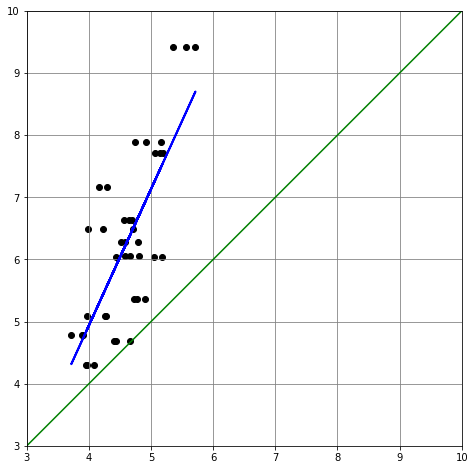

In [70]:
# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(bothtrim_df['metabolics_all_avg_mean_x'],
    bothtrim_df['metabolics_all_avg_mean_y'],
    c='black')
plt.plot(bothtrim_df['metabolics_all_avg_mean_x'],
    predictions,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
plt.xlim((3,10))
plt.ylim((3,10))
plt.show()

In [71]:
#######################################################
## single decision tree implementation
X_dt = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_dt = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt,Y_dt,test_size=0.15,random_state=12)
x_train_dt = X_dt[0:30,:]
temp = X_dt[36:-1,:]
x_train_dt = np.append(x_train_dt, temp, axis=0)
y_train_dt = Y_dt[0:30,:]
temp2 = Y_dt[36:-1,:]
y_train_dt = np.append(y_train_dt, temp2, axis=0)
x_test_dt = X_dt[30:36,:]
y_test_dt = Y_dt[30:36,:]

print(x_train_dt.shape)
print(y_train_dt.shape)
print(x_test_dt.shape)
print(y_test_dt.shape)

# x_train = x_train.reshape(-1,)
y_train_dt = y_train_dt.reshape(-1,)
# x_test_dt = x_test_dt.reshape(-1,)
y_test_dt = y_test_dt.reshape(-1,)
# print(x_train_dt.shape)
# print(y_train_dt.shape)

DecisionTreeRegModel = DecisionTreeRegressor(random_state=13, criterion='mse')
DecisionTreeRegModel.fit(x_train_dt, y_train_dt)



(34, 1)
(34, 1)
(6, 1)
(6, 1)


DecisionTreeRegressor(random_state=13)

y_test_dt:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_dt:
[6.040289 7.890412 6.040289 4.682754 6.282373 6.282373]

RMSE: 1.125049


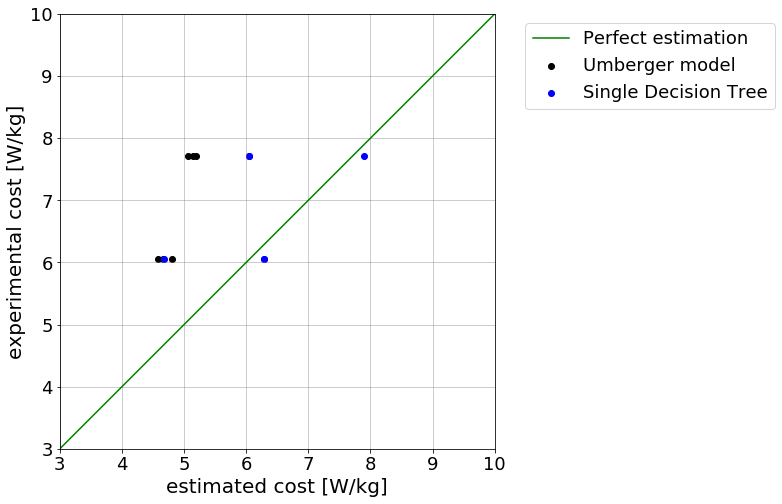

In [72]:
# try some predictions
print('y_test_dt:')
print(y_test_dt)
y_pred_dt = DecisionTreeRegModel.predict(x_test_dt)
print('y_pred_dt:')
print(y_pred_dt)

# error
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print('\nRMSE: %f' % rmse_dt)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_dt,y_test_dt,
    c='black', label='Umberger model')
plt.scatter(y_pred_dt, y_test_dt,
    c='blue', label='Single Decision Tree')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [73]:
########################################################
## random forest implementation

X_rf = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_rf = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf,Y_rf,test_size=0.15,random_state=12)
x_train_rf = X_rf[0:30,:]
temp = X_rf[36:-1,:]
x_train_rf = np.append(x_train_rf, temp, axis=0)
y_train_rf = Y_rf[0:30,:]
temp2 = Y_rf[36:-1,:]
y_train_rf = np.append(y_train_rf, temp2, axis=0)
x_test_rf = X_rf[30:36,:]
y_test_rf = Y_rf[30:36,:]




# x_train_rf = x_train_rf.reshape(-1,)
y_train_rf = y_train_rf.reshape(-1,)
# x_test_rf = x_test_rf.reshape(-1,)
y_test_rf = y_test_rf.reshape(-1,)
# print(x_train_rf.shape)
# print(y_train_rf.shape)

RandomForestRegModel = RandomForestRegressor(random_state=13, n_estimators=50)
RandomForestRegModel.fit(x_train_rf, y_train_rf)



RandomForestRegressor(n_estimators=50, random_state=13)

y_test_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[6.69272796 7.43277716 6.6557255  5.37520434 6.38251916 6.37262628]

RMSE: 0.693460


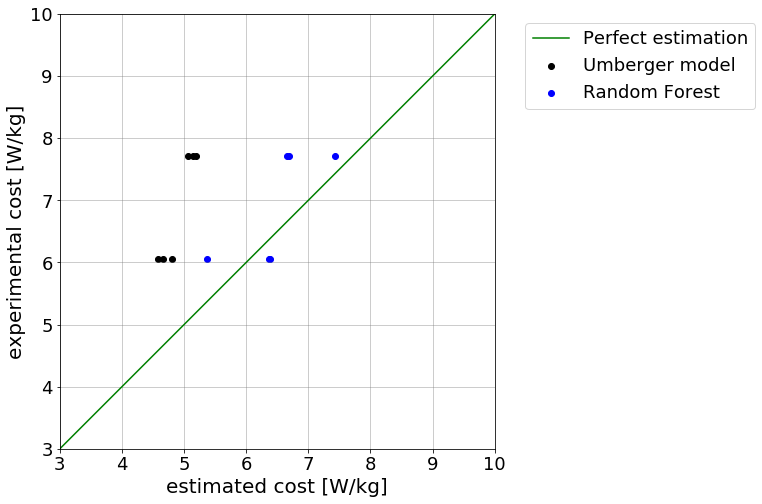

In [74]:
# try some predictions
print('y_test_rf:')
print(y_test_rf)
y_pred_rf = RandomForestRegModel.predict(x_test_rf)
print('y_pred_rf:')
print(y_pred_rf)

# error
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('\nRMSE: %f' % rmse_rf)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_rf,y_test_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_rf, y_test_rf,
    c='blue', label='Random Forest')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Getting X  values with all the umberger components

In [92]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
muscle_df.drop([40], inplace=True)
muscle_df.reset_index(inplace=True,drop=True)

print(muscle_df)

    metabolics_all_avg  metabolics_act_avg  metabolics_short_avg  \
0             5.054988            2.163104              1.745012   
1             4.443187            1.812768              1.560882   
2             5.182183            2.098366              2.220253   
3             4.405230            1.772767              1.353764   
4             4.653218            1.873235              1.571584   
5             4.432866            1.833161              1.418528   
6             4.577935            2.038594              1.565956   
7             4.519551            1.935891              1.671981   
8             4.792660            2.111974              1.587234   
9             3.964115            1.582758              1.408510   
10            4.281854            1.670328              1.270100   
11            4.256257            1.638048              1.319619   
12            4.557572            2.099804              1.351984   
13            4.638953            2.150757      

In [85]:
# figure out how to pair down the experimental to only have these ones
combos = []
for index, row in muscle_df.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    combos.append((subj,cond,trial))
combosunique = set(combos)
# print(combosunique)

idk = pd.merge(expmetcost_df, muscle_df, how='left', indicator=True)
idk2 = idk.reset_index()

indextodrop = []
for index, row in idk2.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    if (subj,cond,trial) not in combosunique:
        indextodrop.append(index)

idk3 = idk2.drop(indextodrop)
# print(idk3)
idk4 = idk3.drop(['index','_merge','metabolics_mech_avg','metabolics_basal_avg','metabolics_short_avg','metabolics_act_avg'], axis=1)
# print(idk4)
# sort the dataframe TODO sort the sims one the same way
idk5 = idk4.sort_values(by=['subjectname','condname','trialname'])
idk5.reset_index(inplace=True,drop=True)

exp_df = idk5
# print(exp_df)


# linear regression on multiple values

In [96]:
# exp_df
# muscle_df

############################################################################
# linear regression model
X_multi_lg = muscle_df.iloc[:,0:5].values
# print('x')
print(X_multi_lg.shape)
Y_multi_lg = exp_df.iloc[:,0].values
# print('y')
print(Y_multi_lg.shape)

# split into sets
# x_train_multi_lg,x_test_multi_lg,y_train_multi_lg,y_test_multi_lg = train_test_split(X_multi_lg,Y_multi_lg,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_lg = X_multi_lg[0:30,:]
temp = X_multi_lg[36:-1,:]
x_train_multi_lg = np.append(x_train_multi_lg, temp, axis=0)
y_train_multi_lg = Y_multi_lg[0:30]
temp2 = Y_multi_lg[36:-1]
y_train_multi_lg = np.append(y_train_multi_lg, temp2, axis=0)
x_test_multi_lg = X_multi_lg[30:36,:]
y_test_multi_lg = Y_multi_lg[30:36]

# set up the regression
reg_multi_lg = LinearRegression()
reg_multi_lg.fit(x_train_multi_lg,y_train_multi_lg)

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_multi_lg_test = reg_multi_lg.predict(x_test_multi_lg)
y_pred_multi_lg_train = reg_multi_lg.predict(x_train_multi_lg)

# baseline error
mse_baseline = mean_squared_error(Y_multi_lg,X_multi_lg[:,0])
rmse_baseline = np.sqrt(mse_baseline)
print('\nRMSE baseline: %f W/kg' % rmse_baseline)

mse_multi_lg_train = mean_squared_error(y_train_multi_lg, y_pred_multi_lg_train)
rmse_multi_lg_train = np.sqrt(mse_multi_lg_train)
print('\nRMSE training linear regression %f W/kg' % rmse_multi_lg_train)

mse_multi_lg_test = mean_squared_error(y_test_multi_lg, y_pred_multi_lg_test)
rmse_multi_lg_test = np.sqrt(mse_multi_lg_test)
print('\nRMSE test linear regression %f W/kg' % rmse_multi_lg_test)

(41, 5)
(41,)

RMSE baseline: 1.976288 W/kg

RMSE training linear regression 0.830225 W/kg

RMSE test linear regression 0.503557 W/kg


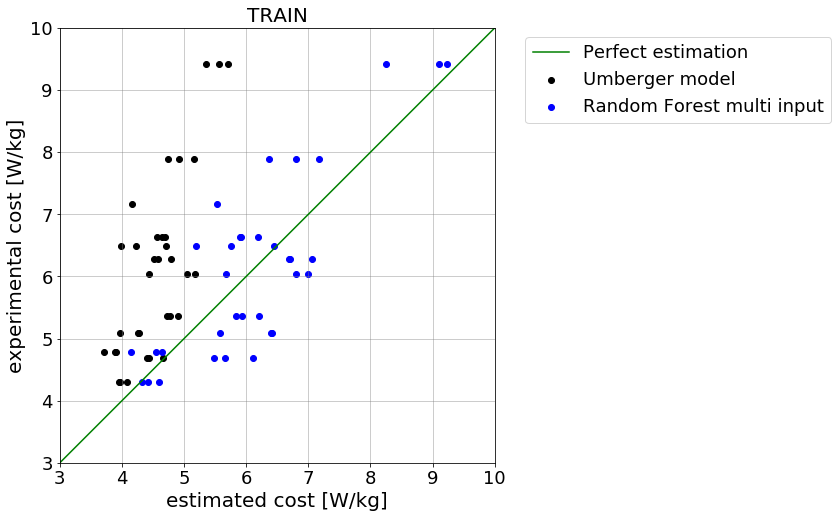

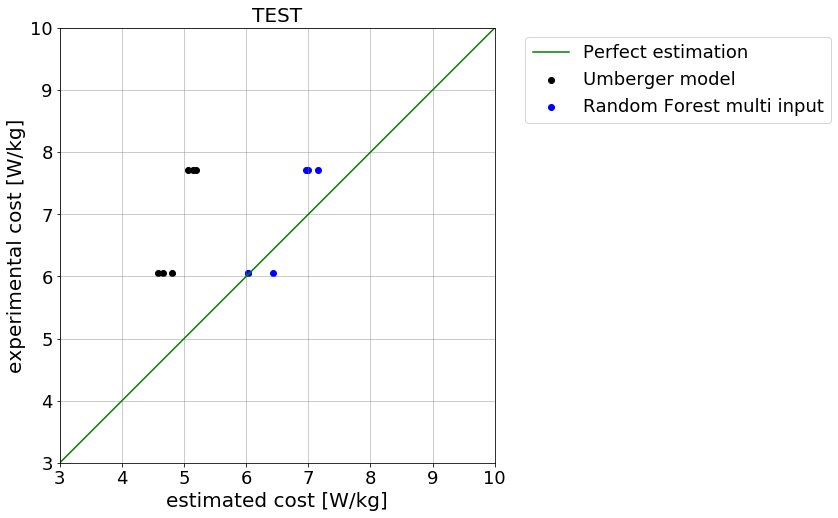

In [98]:
# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_lg[:,0],y_train_multi_lg,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_lg_train, y_train_multi_lg,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_lg[:,0],y_test_multi_lg,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_lg_test, y_test_multi_lg,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## random forest for all umberger inputs

In [111]:
# set up the X and Y
X_multi_rf = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf = X_multi_rf[0:30,:]
temp = X_multi_rf[36:-1,:]
x_train_multi_rf = np.append(x_train_multi_rf, temp, axis=0)
y_train_multi_rf = Y_multi_rf[0:30]
temp2 = Y_multi_rf[36:-1]
y_train_multi_rf = np.append(y_train_multi_rf, temp2, axis=0)
x_test_multi_rf = X_multi_rf[30:36,:]
y_test_multi_rf = Y_multi_rf[30:36]




# print(X_multi_rf.shape)
# print(Y_multi_rf.shape)

print(x_train_multi_rf.shape)
print(y_train_multi_rf.shape)
print(x_test_multi_rf.shape)
print(y_test_multi_rf.shape)

multiregrf = RandomForestRegressor(n_estimators=100, random_state=13)
multiregrf.fit(x_train_multi_rf,y_train_multi_rf)
y_pred_multi_rf = multiregrf.predict(x_test_multi_rf)
y_pred_multi_rf_train = multiregrf.predict(x_train_multi_rf)


(34, 5)
(34,)
(6, 5)
(6,)


y_test_multi_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[7.18435102 7.60293609 6.20313636 6.36337094 6.99860502 5.93257001]

RMSE baseline: 1.976288

RMSE training: 0.399358

RMSE test: 0.767837


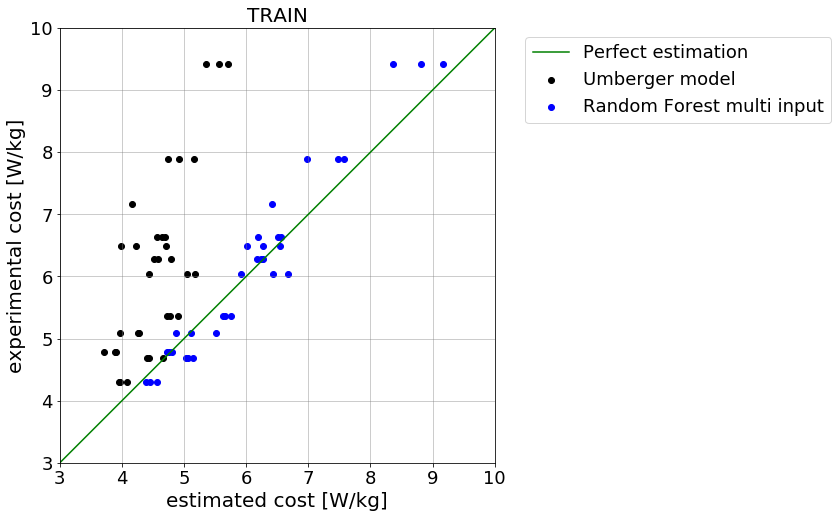

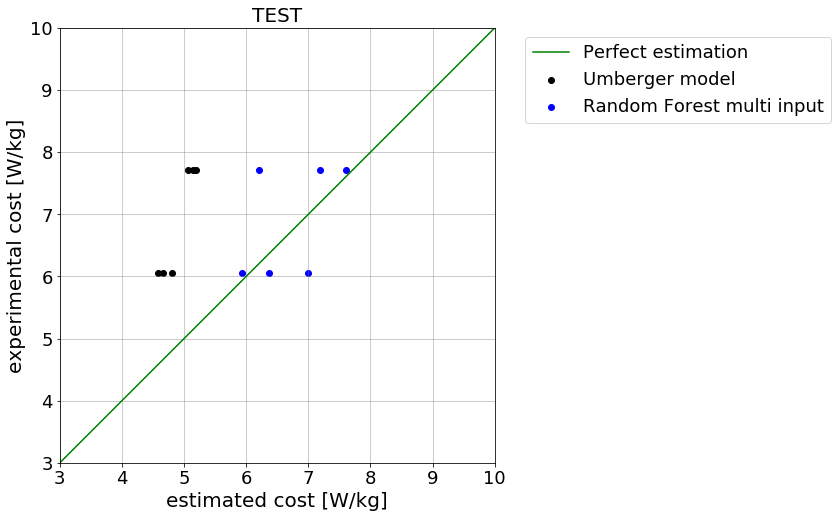

In [112]:
# try some predictions
print('y_test_multi_rf:')
print(y_test_multi_rf)
print('y_pred_rf:')
print(y_pred_multi_rf)

# error
mse_multi_rf_base = mean_squared_error(Y_multi_rf,X_multi_rf[:,0])
rmse_multi_rf_base = np.sqrt(mse_multi_rf_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_base)

mse_multi_rf_train = mean_squared_error(y_train_multi_rf, y_pred_multi_rf_train)
rmse_multi_rf_train = np.sqrt(mse_multi_rf_train)
print('\nRMSE training: %f' % rmse_multi_rf_train)

mse_multi_rf = mean_squared_error(y_test_multi_rf, y_pred_multi_rf)
rmse_multi_rf = np.sqrt(mse_multi_rf)
print('\nRMSE test: %f' % rmse_multi_rf)

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf[:,0],y_train_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_train, y_train_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf[:,0],y_test_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf, y_test_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [113]:
# get importance of features
importance = list(multiregrf.feature_importances_)
print(importance)

featurelist = list(muscle_df.columns)
# featurelist.remove(['subjectname','condname','experimentname','trialname'])
featurelist.remove('subjectname')
featurelist.remove('condname')
featurelist.remove('experimentname')
featurelist.remove('trialname')

# list of tubles with variable and importance
feature_importances = [(feature, round(importance,2)) for feature, importance in zip(featurelist,importance)]

# sort the feature importances bu most important 
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

[0.4751609973979485, 0.23110797528369062, 0.08518203200666513, 0.0, 0.20854899531169566]
Variable: metabolics_all_avg   Importance: 0.48
Variable: metabolics_act_avg   Importance: 0.23
Variable: metabolics_mech_avg  Importance: 0.21
Variable: metabolics_short_avg Importance: 0.09
Variable: metabolics_basal_avg Importance: 0.0


[None, None, None, None, None]

## try a subject calibration for 2 subjects

In [118]:
# random forest model with one example from a subject (simulate a calibration)
# set up the X and Y
X_multi_rf_calib = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf_calib = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf_calib = X_multi_rf_calib[0:31,:]
temp = X_multi_rf_calib[35:-1,:]
x_train_multi_rf_calib = np.append(x_train_multi_rf_calib, temp, axis=0)
y_train_multi_rf_calib = Y_multi_rf_calib[0:31]
temp2 = Y_multi_rf_calib[35:-1]
y_train_multi_rf_calib = np.append(y_train_multi_rf_calib, temp2, axis=0)
x_test_multi_rf_calib = X_multi_rf_calib[31:35,:]
y_test_multi_rf_calib = Y_multi_rf_calib[31:35]

# print(X_multi_rf_calib.shape)
# print(Y_multi_rf_calib.shape)

print(x_train_multi_rf_calib.shape)
print(y_train_multi_rf_calib.shape)
print(x_test_multi_rf_calib.shape)
print(y_test_multi_rf_calib.shape)

multiregrf_calib = RandomForestRegressor(n_estimators=1000, random_state=13)
multiregrf_calib.fit(x_train_multi_rf_calib,y_train_multi_rf_calib)
y_pred_multi_rf_calib = multiregrf_calib.predict(x_test_multi_rf_calib)
y_pred_multi_rf_calib_train = multiregrf_calib.predict(x_train_multi_rf_calib)


# try some predictions
print('y_test_multi_rf_calib:')
print(y_test_multi_rf_calib)
print('y_pred_rf_calib:')
print(y_pred_multi_rf_calib)

# error
mse_multi_rf_calib_base = mean_squared_error(Y_multi_rf_calib,X_multi_rf_calib[:,0])
rmse_multi_rf_calib_base = np.sqrt(mse_multi_rf_calib_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_calib_base)

mse_multi_rf_calib_train = mean_squared_error(y_train_multi_rf_calib, y_pred_multi_rf_calib_train)
rmse_multi_rf_calib_train = np.sqrt(mse_multi_rf_calib_train)
print('\nRMSE training: %f' % rmse_multi_rf_calib_train)

mse_multi_rf_calib = mean_squared_error(y_test_multi_rf_calib, y_pred_multi_rf_calib)
rmse_multi_rf_calib = np.sqrt(mse_multi_rf_calib)
print('\nRMSE test: %f' % rmse_multi_rf_calib)

(36, 5)
(36,)
(4, 5)
(4,)
y_test_multi_rf_calib:
[7.708152 7.708152 6.061044 6.061044]
y_pred_rf_calib:
[7.66125296 6.28014376 6.49602861 7.08379578]

RMSE baseline: 1.976288

RMSE training: 0.369119

RMSE test: 0.905075


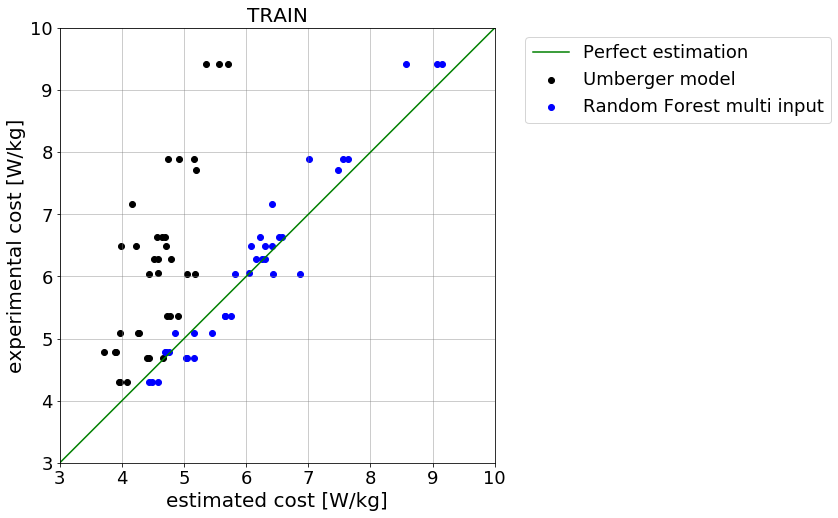

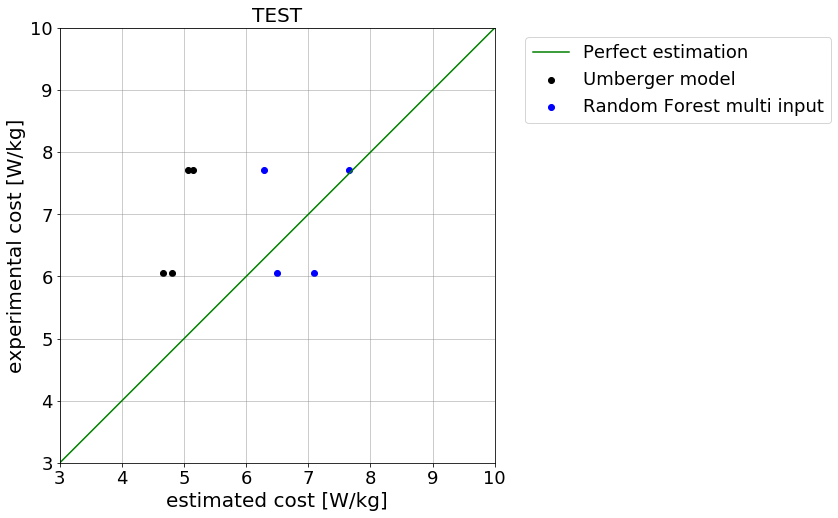

In [119]:

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf_calib[:,0],y_train_multi_rf_calib,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_calib_train, y_train_multi_rf_calib,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf_calib[:,0],y_test_multi_rf_calib,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_calib, y_test_multi_rf_calib,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## try deep learning model

In [33]:
# set up the X and Y
X_multi_nn = muscle_df.iloc[:,0:5].values
# print(X_multi_nn)
Y_multi_nn = exp_df.iloc[:,0].values.reshape(-1,1)
# print(Y_multi_nn.shape)

# split into sets
# x_train_multi_nn,x_test_multi_nn,y_train_multi_nn,y_test_multi_nn = train_test_split(X_multi_nn,Y_multi_nn,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_nn = X_multi_nn[0:30,:]
temp = X_multi_nn[36:-1,:]
x_train_multi_nn = np.append(x_train_multi_nn, temp, axis=0)
y_train_multi_nn = Y_multi_nn[0:30]
temp2 = Y_multi_nn[36:-1]
y_train_multi_nn = np.append(y_train_multi_nn, temp2, axis=0)
x_test_multi_nn = X_multi_nn[30:36,:]
y_test_multi_nn = Y_multi_nn[30:36]

# reshape
x_train_multi_nn.reshape



# print(X_multi_nn.shape)
# print(Y_multi_nn.shape)

print(x_train_multi_nn.shape)
print(y_train_multi_nn.shape)
print(x_test_multi_nn.shape)
print(y_test_multi_nn.shape)


(35, 5)
(35, 1)
(6, 5)
(6, 1)


In [34]:
# model create and train
import numpy as np
from keras import layers
from keras.layers import Input, Dense #, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
# from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



# from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
# K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [53]:
# create the base model
def baseline_model(input_shape):
    
#     # create the model
#     model = Sequential()
#     model.add(Dense(5, input_dim=5, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(4, kernel_initializer='normal'))
#     model.add(Dense(2, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
    
    X_input = Input(input_shape)
    
    X = Dense(15, input_dim=input_shape, kernel_initializer='normal', activation='relu')(X_input)
    X = Dense(30, activation='relu', kernel_initializer='normal')(X)
    X = Dense(15, activation='relu', kernel_initializer='normal')(X)
    X = Dense(3, activation='relu', kernel_initializer='normal')(X)
    X = Dense(1, kernel_initializer='normal', activation='linear')(X)
    
    model = Model(inputs=X_input, outputs=X, name='baselineModel')
    
    
    return model

In [54]:
# evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, verbose=0)
# kfold = KFold(n_splits=7)
# results = cross_val_score(estimator, x_train_multi_nn, y_train_multi_nn, cv=kfold)
# results = cross_val_score(estimator, X_multi_nn, Y_multi_nn, cv=kfold)

# print('Baseline: %.2f (%.2f) MSE' % (results.mean(), results.std()))
x_train_multi_nn.shape[1:]

(5,)

In [55]:
# create the model
basemodel = baseline_model(x_train_multi_nn.shape[1:])

In [56]:
basemodel.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [57]:
basemodel.fit(x=x_train_multi_nn, y=y_train_multi_nn, epochs=1000)

Epoch 1/1000
35/35 [==============================] - 0s 13ms/step - loss: 39.8753 - mean_squared_error: 39.8753
Epoch 2/1000
35/35 [==============================] - 0s 171us/step - loss: 39.8503 - mean_squared_error: 39.8503
Epoch 3/1000
35/35 [==============================] - 0s 171us/step - loss: 39.8231 - mean_squared_error: 39.8231
Epoch 4/1000
35/35 [==============================] - 0s 142us/step - loss: 39.7956 - mean_squared_error: 39.7956
Epoch 5/1000
35/35 [==============================] - 0s 114us/step - loss: 39.7674 - mean_squared_error: 39.7674
Epoch 6/1000
35/35 [==============================] - 0s 143us/step - loss: 39.7392 - mean_squared_error: 39.7392
Epoch 7/1000
35/35 [==============================] - 0s 171us/step - loss: 39.7098 - mean_squared_error: 39.7098
Epoch 8/1000
35/35 [==============================] - 0s 113us/step - loss: 39.6800 - mean_squared_error: 39.6800
Epoch 9/1000
35/35 [==============================] - 0s 171us/step - loss: 39.6497 - mea

35/35 [==============================] - 0s 142us/step - loss: 1.5278 - mean_squared_error: 1.5278
Epoch 73/1000
35/35 [==============================] - 0s 171us/step - loss: 1.4302 - mean_squared_error: 1.4302
Epoch 74/1000
35/35 [==============================] - 0s 142us/step - loss: 1.3597 - mean_squared_error: 1.3597
Epoch 75/1000
35/35 [==============================] - 0s 527us/step - loss: 1.3281 - mean_squared_error: 1.3281
Epoch 76/1000
35/35 [==============================] - 0s 143us/step - loss: 1.3109 - mean_squared_error: 1.3109
Epoch 77/1000
35/35 [==============================] - 0s 142us/step - loss: 1.3011 - mean_squared_error: 1.3011
Epoch 78/1000
35/35 [==============================] - 0s 142us/step - loss: 1.3018 - mean_squared_error: 1.3018
Epoch 79/1000
35/35 [==============================] - 0s 142us/step - loss: 1.3027 - mean_squared_error: 1.3027
Epoch 80/1000
35/35 [==============================] - 0s 143us/step - loss: 1.3119 - mean_squared_error: 1.31

35/35 [==============================] - 0s 142us/step - loss: 1.2548 - mean_squared_error: 1.2548
Epoch 145/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2575 - mean_squared_error: 1.2575
Epoch 146/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2696 - mean_squared_error: 1.2696
Epoch 147/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2935 - mean_squared_error: 1.2935
Epoch 148/1000
35/35 [==============================] - 0s 114us/step - loss: 1.3035 - mean_squared_error: 1.3035
Epoch 149/1000
35/35 [==============================] - 0s 114us/step - loss: 1.3012 - mean_squared_error: 1.3012
Epoch 150/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2948 - mean_squared_error: 1.2948
Epoch 151/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2920 - mean_squared_error: 1.2920
Epoch 152/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2978 - mean_squared_err

35/35 [==============================] - 0s 114us/step - loss: 1.2187 - mean_squared_error: 1.2187
Epoch 217/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2338 - mean_squared_error: 1.2338
Epoch 218/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2531 - mean_squared_error: 1.2531
Epoch 219/1000
35/35 [==============================] - 0s 143us/step - loss: 1.2459 - mean_squared_error: 1.2459
Epoch 220/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2319 - mean_squared_error: 1.2319
Epoch 221/1000
35/35 [==============================] - 0s 143us/step - loss: 1.2190 - mean_squared_error: 1.2190
Epoch 222/1000
35/35 [==============================] - 0s 199us/step - loss: 1.2191 - mean_squared_error: 1.2191
Epoch 223/1000
35/35 [==============================] - 0s 143us/step - loss: 1.2160 - mean_squared_error: 1.2160
Epoch 224/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2324 - mean_squared_err

35/35 [==============================] - 0s 142us/step - loss: 1.1888 - mean_squared_error: 1.1888
Epoch 289/1000
35/35 [==============================] - 0s 171us/step - loss: 1.1934 - mean_squared_error: 1.1934
Epoch 290/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2072 - mean_squared_error: 1.2072
Epoch 291/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2189 - mean_squared_error: 1.2189
Epoch 292/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2220 - mean_squared_error: 1.2220
Epoch 293/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2139 - mean_squared_error: 1.2139
Epoch 294/1000
35/35 [==============================] - 0s 142us/step - loss: 1.2010 - mean_squared_error: 1.2010
Epoch 295/1000
35/35 [==============================] - 0s 85us/step - loss: 1.1860 - mean_squared_error: 1.1860
Epoch 296/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1840 - mean_squared_erro

35/35 [==============================] - 0s 142us/step - loss: 1.1731 - mean_squared_error: 1.1731
Epoch 360/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1755 - mean_squared_error: 1.1755
Epoch 361/1000
35/35 [==============================] - 0s 143us/step - loss: 1.1732 - mean_squared_error: 1.1732
Epoch 362/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1660 - mean_squared_error: 1.1660
Epoch 363/1000
35/35 [==============================] - 0s 143us/step - loss: 1.1615 - mean_squared_error: 1.1615
Epoch 364/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1617 - mean_squared_error: 1.1617
Epoch 365/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1664 - mean_squared_error: 1.1664
Epoch 366/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1805 - mean_squared_error: 1.1805
Epoch 367/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1815 - mean_squared_err

35/35 [==============================] - 0s 143us/step - loss: 1.1348 - mean_squared_error: 1.1348
Epoch 432/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1340 - mean_squared_error: 1.1340
Epoch 433/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1331 - mean_squared_error: 1.1331
Epoch 434/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1327 - mean_squared_error: 1.1327
Epoch 435/1000
35/35 [==============================] - 0s 129us/step - loss: 1.1331 - mean_squared_error: 1.1331
Epoch 436/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1335 - mean_squared_error: 1.1335
Epoch 437/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1322 - mean_squared_error: 1.1322
Epoch 438/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1316 - mean_squared_error: 1.1316
Epoch 439/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1310 - mean_squared_err

35/35 [==============================] - 0s 142us/step - loss: 1.2936 - mean_squared_error: 1.2936
Epoch 503/1000
35/35 [==============================] - 0s 114us/step - loss: 1.2638 - mean_squared_error: 1.2638
Epoch 504/1000
35/35 [==============================] - 0s 85us/step - loss: 1.2163 - mean_squared_error: 1.2163
Epoch 505/1000
35/35 [==============================] - 0s 114us/step - loss: 1.1606 - mean_squared_error: 1.1606
Epoch 506/1000
35/35 [==============================] - 0s 143us/step - loss: 1.1336 - mean_squared_error: 1.1336
Epoch 507/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1173 - mean_squared_error: 1.1173
Epoch 508/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1040 - mean_squared_error: 1.1040
Epoch 509/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1176 - mean_squared_error: 1.1176
Epoch 510/1000
35/35 [==============================] - 0s 171us/step - loss: 1.1459 - mean_squared_erro

35/35 [==============================] - 0s 114us/step - loss: 1.0902 - mean_squared_error: 1.0902
Epoch 574/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0918 - mean_squared_error: 1.0918
Epoch 575/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0913 - mean_squared_error: 1.0913
Epoch 576/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0892 - mean_squared_error: 1.0892
Epoch 577/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0899 - mean_squared_error: 1.0899
Epoch 578/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0862 - mean_squared_error: 1.0862
Epoch 579/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0862 - mean_squared_error: 1.0862
Epoch 580/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0860 - mean_squared_error: 1.0860
Epoch 581/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0855 - mean_squared_err

35/35 [==============================] - 0s 114us/step - loss: 1.0714 - mean_squared_error: 1.0714
Epoch 646/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0754 - mean_squared_error: 1.0754
Epoch 647/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0767 - mean_squared_error: 1.0767
Epoch 648/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0826 - mean_squared_error: 1.0826
Epoch 649/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0797 - mean_squared_error: 1.0797
Epoch 650/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0704 - mean_squared_error: 1.0704
Epoch 651/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0671 - mean_squared_error: 1.0671
Epoch 652/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0768 - mean_squared_error: 1.0768
Epoch 653/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0947 - mean_squared_err

35/35 [==============================] - 0s 142us/step - loss: 1.0555 - mean_squared_error: 1.0555
Epoch 718/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0539 - mean_squared_error: 1.0539
Epoch 719/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0581 - mean_squared_error: 1.0581
Epoch 720/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0533 - mean_squared_error: 1.0533
Epoch 721/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0495 - mean_squared_error: 1.0495
Epoch 722/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0568 - mean_squared_error: 1.0568
Epoch 723/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0726 - mean_squared_error: 1.0726
Epoch 724/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0707 - mean_squared_error: 1.0707
Epoch 725/1000
35/35 [==============================] - 0s 137us/step - loss: 1.0642 - mean_squared_err

35/35 [==============================] - 0s 142us/step - loss: 1.0417 - mean_squared_error: 1.0417
Epoch 790/1000
35/35 [==============================] - 0s 130us/step - loss: 1.0441 - mean_squared_error: 1.0441
Epoch 791/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0448 - mean_squared_error: 1.0448
Epoch 792/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0454 - mean_squared_error: 1.0454
Epoch 793/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0473 - mean_squared_error: 1.0473
Epoch 794/1000
35/35 [==============================] - 0s 171us/step - loss: 1.0452 - mean_squared_error: 1.0452
Epoch 795/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0400 - mean_squared_error: 1.0400
Epoch 796/1000
35/35 [==============================] - 0s 170us/step - loss: 1.0338 - mean_squared_error: 1.0338
Epoch 797/1000
35/35 [==============================] - 0s 171us/step - loss: 1.0387 - mean_squared_err

35/35 [==============================] - 0s 171us/step - loss: 1.0354 - mean_squared_error: 1.0354
Epoch 861/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0511 - mean_squared_error: 1.0511
Epoch 862/1000
35/35 [==============================] - 0s 158us/step - loss: 1.0799 - mean_squared_error: 1.0799
Epoch 863/1000
35/35 [==============================] - 0s 142us/step - loss: 1.1039 - mean_squared_error: 1.1039
Epoch 864/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0950 - mean_squared_error: 1.0950
Epoch 865/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0674 - mean_squared_error: 1.0674
Epoch 866/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0468 - mean_squared_error: 1.0468
Epoch 867/1000
35/35 [==============================] - 0s 143us/step - loss: 1.0374 - mean_squared_error: 1.0374
Epoch 868/1000
35/35 [==============================] - 0s 285us/step - loss: 1.0241 - mean_squared_err

35/35 [==============================] - 0s 142us/step - loss: 1.0325 - mean_squared_error: 1.0325
Epoch 932/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0510 - mean_squared_error: 1.0510
Epoch 933/1000
35/35 [==============================] - 0s 148us/step - loss: 1.0744 - mean_squared_error: 1.0744
Epoch 934/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0843 - mean_squared_error: 1.0843
Epoch 935/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0923 - mean_squared_error: 1.0923
Epoch 936/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0770 - mean_squared_error: 1.0770
Epoch 937/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0379 - mean_squared_error: 1.0379
Epoch 938/1000
35/35 [==============================] - 0s 142us/step - loss: 1.0245 - mean_squared_error: 1.0245
Epoch 939/1000
35/35 [==============================] - 0s 114us/step - loss: 1.0151 - mean_squared_err

In [58]:
preds = basemodel.evaluate(x=x_test_multi_nn, y=y_test_multi_nn)
print()
print('Loss = ' + str(preds[0]))
print('test MSE = ' + str(preds[1]))

6/6 [==============================] - 0s 12ms/step

Loss = 0.29591646790504456
test MSE = 0.29591646790504456


In [59]:
y_pred_train_multi_nn = basemodel.predict(x=x_train_multi_nn)
y_pred_test_multi_nn = basemodel.predict(x=x_test_multi_nn)

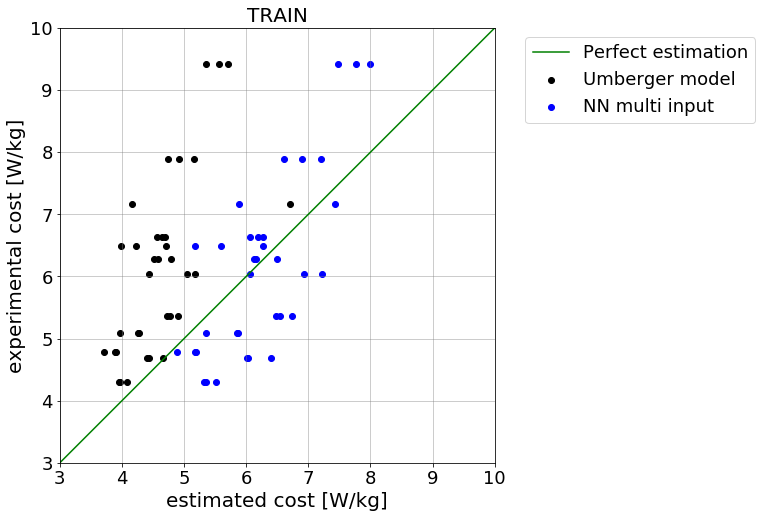

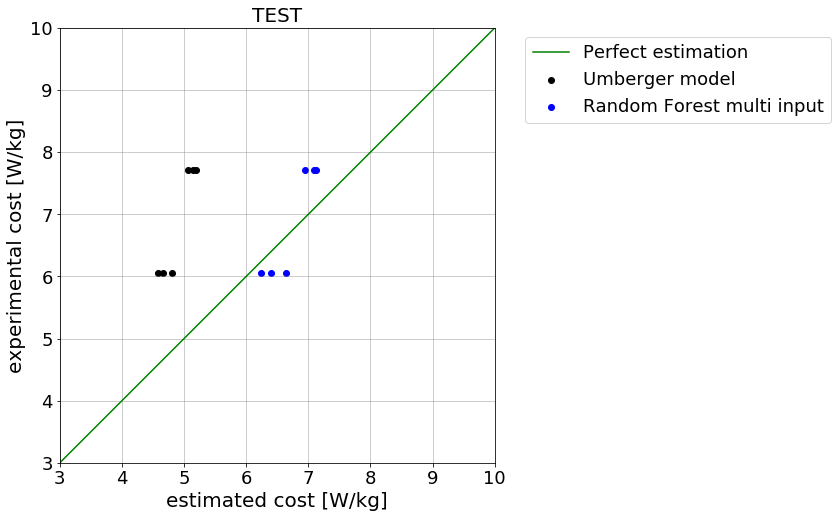

In [60]:
# try some predictions

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_nn[:,0],y_train_multi_nn,
    c='black', label='Umberger model')
plt.scatter(y_pred_train_multi_nn, y_train_multi_nn,
    c='blue', label='NN multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_nn[:,0],y_test_multi_nn,
    c='black', label='Umberger model')
plt.scatter(y_pred_test_multi_nn, y_test_multi_nn,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()